# Test Huperspectral Images HSI

### A clas to handle the HSI image

In [162]:
# dependencies 
from spectral import *
import plotly.express as px
from scipy.io import loadmat
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go   
import warnings
import numpy as np 







warnings.filterwarnings("ignore")

In [4]:
class open_hsi:
    
    '''We first have to import the spectral module and then we can use 
    the open_image function to open the image in case it's a .lan format.
    In the case of .mat format, we have to use the scipy.io.loadmat function
    In the case of .tif or .tiff format, we have to use the cv2.imread function'''
    def __init__(self, hsipath):
        self.hsipath = hsipath
    def get_extention(self):
        '''This function returns the extention of the file'''
        return self.hsipath.split('.')[-1]
    def open_image(self):
        '''This function opens the image and returns the array of the image (width, height, band)'''
        if self.get_extention() == 'mat':
            ''' When opening the .mat file, 
            the image data is usualy stored on
            the last key of the dictionnary.''' 
            pref_mat = loadmat(self.hsipath)
            im_array = pref_mat[list(pref_mat.keys())[-1]] 
            return im_array
        if self.get_extention() == 'lan':
            
            im_spectral = open_image(self.hsipath)
            im_spectral = im_spectral.load()
            return im_spectral
        
        if (self.get_extention() == 'tif') or (self.get_extention() == 'tiff'):
            im_array = cv2.imread(self.hsipath)
            return im_array
        else :
            print('The file extention is not supported')
        
        
    def normalize(self):
        '''This function normalizes the array of 
        the image so that for each band we get a grayscale image
        note: this returns a float array, if an int array is needed
        the conversion must be done manually'''
        im_array = self.open_image()
        im_array = im_array.astype(float)
        im_array = (((im_array-im_array.min()) / (im_array.max()-im_array.min()))*255).astype('uint8')
        return im_array
    def view_image(self, band):
        
        '''This function plots the grayscale image of the hyperspectral cube's band'''
        im_array = self.normalize()
        fig = px.imshow(im_array[:,:,band],color_continuous_scale='gray')
        fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
        fig.show()
        
    def get_image(self, band):
        '''This function returns the grayscale image of the hyperspectral cube's band'''
        im_array = self.normalize()
        return im_array[:,:,band]
    
    def video(self, fps =5.0):
        '''This function returns a video of the hyperspectral cube'''
        im_array = self.normalize()
        height,width,layers=im_array.shape
        filename = f'output_video_{time.strftime("%Y%m%d-%H%M%S")}.mp4'
        video = cv2.VideoWriter(filename ,cv2.VideoWriter_fourcc(*'MP4V'), fps,
                                (width,height), isColor = False)
        images = []
        for i in range(0,layers-1):
            images.append(im_array[:,:,i])
            data = np.array(im_array[:,:,i], np.uint8)
            video.write(data)
        video.release()
        cv2.destroyAllWindows()
        print(f'The video has been saved successfully under the name: {filename}')
        
        #return images
        

In [5]:
class open_hsi_mask(open_hsi):
    def __init__(self, hsipath, maskpath):
        ''' This function initializes the class with the path of the hyperspectral image and the path of the mask'''
        super().__init__(hsipath)
        self.maskpath = maskpath
    
        
    def get_extention(self):
        '''This function returns the extention of the file'''
        return self.maskpath.split('.')[-1]
    
    def open_ground_truth(self):
        '''This function reads the ground truth file and returns a numpy array'''
        if self.get_extention() == 'mat':
            pref_mat = loadmat(self.maskpath)
            im_array_gt = pref_mat[list(pref_mat.keys())[-1]]
            return im_array_gt
        if self.get_extention() == 'lan':
            im_spectral_gt = open_image(self.maskpath)
            im_spectral_gt = im_spectral_gt.load()
            return im_spectral_gt
        if (self.get_extention() == 'tif') or (self.get_extention() == 'tiff'):
            im_array_gt = cv2.imread(self.maskpath)
            return im_array_gt
        else: 
            print('The file extention is not supported')
            
    
    
    def get_class_pixels(self, class_number):
        '''This function returns the pixels of a specific class'''
        im_array_gt = self.open_ground_truth()
        if class_number > im_array_gt.max():
            print('The class number is higher than the maximum number of classes')
            return 0
        if class_number < im_array_gt.min():
            print('The class number is lower than the minimum number of classes')
            return 0

        class_pixels = im_array_gt == class_number
        return class_pixels
    
    def class_number(self):
        im_array_gt = self.open_ground_truth()
        '''This function returns the number of classes in the mask'''
        return int(im_array_gt.max()) - int(im_array_gt.min()) +1  
    

    def get_reflectance(self, class_number):
        '''This function returns the reflectance of a specific class'''
        class_pixels = self.get_class_pixels(class_number)
        im_array = open_hsi(self.hsipath).normalize()
        layers = im_array.shape[2]
        band = []
        reflectance = []
        for i in range(0,layers-1):
            band.append(i)
            filtered_pixels = class_pixels * im_array[:,:,i]
            reflectance.append(filtered_pixels.sum()/class_pixels.sum())
        return reflectance, band
        
    def view_reflectance(self, label= False):
        '''This function plots the reflectance of all classes'''
        plt.figure(figsize=(15,10))
        for i in range(0, self.class_number()):
            reflectance, band = self.get_reflectance(i)
            plt.plot(band, np.log(reflectance), label = label[i-1])
        plt.legend(loc='upper right')


In [7]:
PaviaU_classes = ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets', 'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows', 'Other']

In [8]:
open_hsi('PaviaU.mat').video(1)

The video has been saved successfully under the name: output_video_20221202-140654.mp4


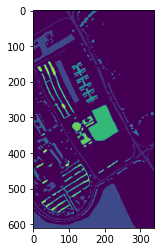

In [29]:
hsi_image = open_hsi('PaviaU.mat').open_image()
hsi_mask = open_hsi_mask('PaviaU.mat','PaviaU_gt.mat').open_ground_truth()
plt.imshow(hsi_mask)

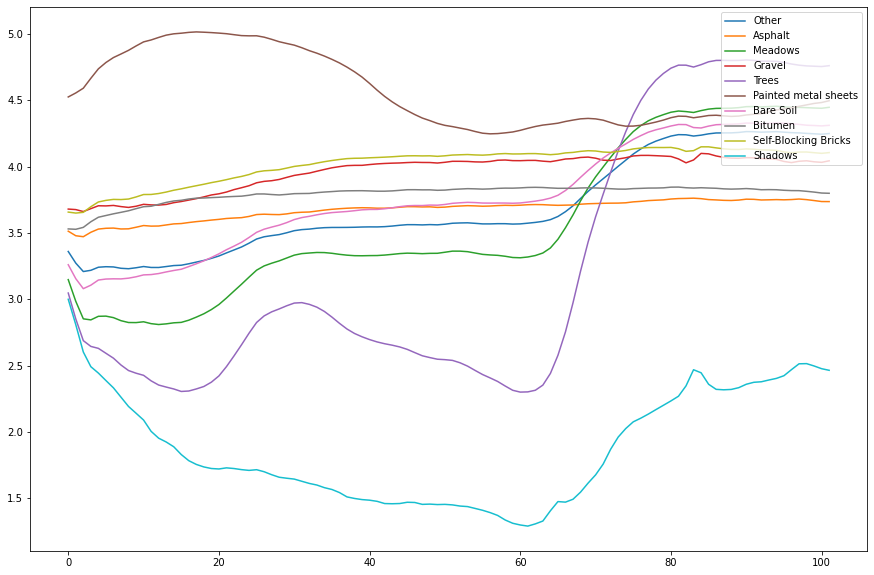

In [10]:
open_hsi_mask('PaviaU.mat','PaviaU_gt.mat').view_reflectance(PaviaU_classes)

### Preprocessing

In [30]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
height, width, layers = hsi_image.shape
# reshape the image to a 1D array of pixels and 103 features
df = pd.DataFrame(hsi_image.reshape(-1,layers)) 
feature_columns = [f'band_{i}' for i in range(layers)]
df.columns = [feature_columns]
# reshape the mask to a 1D array of pixels
df['class'] = hsi_mask.reshape(-1)
# get the features and the labels
y = df['class'].values
X = df.drop('class', axis = 1)

# standardize the features 
#scaler = StandardScaler()
#scaler.fit(X)
#X = scaler.transform(X)
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### We first try a reduction of the dimention of the images

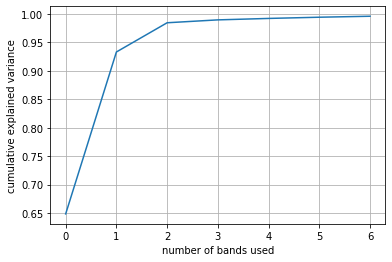

In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

pca = PCA(7).fit(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.xlabel('number of bands used')
plt.ylabel('cumulative explained variance');
X_reduced = pca.transform(X_scaled)

It seems like 7 bands are enough to explain 99% of the variance in the data

### we try a classification with a random forrest algo

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)

print(f'Accuracy for 100 estimators : {acc_score} ')

Accuracy for 100 estimators : 0.8554001928640309 


In [59]:
y_pred = clf.predict(X)
acc_score = accuracy_score(y, y_pred)
print(f'Accuracy for the image : {acc_score} ')

Accuracy for the image : 0.9566200578592092 


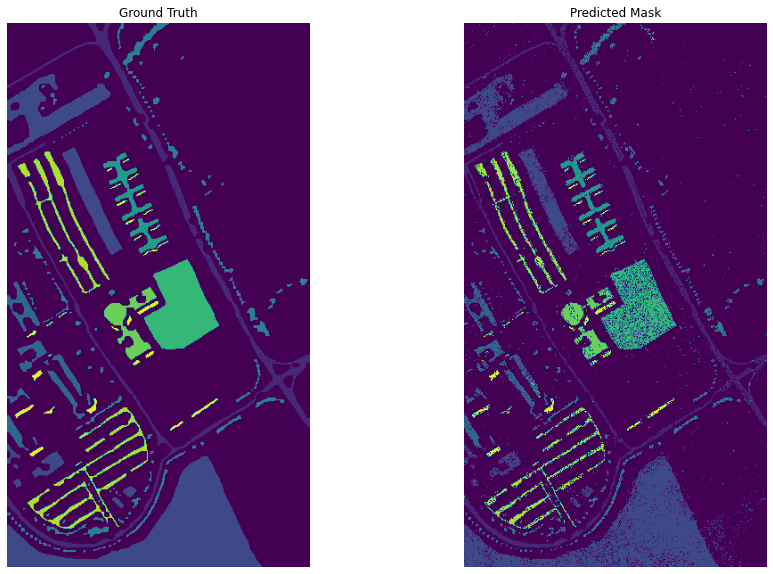

In [60]:
pred_mask = y_pred.reshape(height, width)
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(1,2,1)
ax.axis('off')
ax2 = f.add_subplot(1,2,2)
ax2.axis('off')

ax.imshow(hsi_mask)
ax.title.set_text('Ground Truth')


ax2.imshow(pred_mask)
ax2.title.set_text('Predicted Mask')

In [90]:
def conservative_smoothing_gray(data, filter_size):
    temp = []
    indexer = filter_size // 2
    new_image = data.copy()
    nrow, ncol = data.shape
    for i in range(nrow):
        for j in range(ncol):
            for k in range(i-indexer, i+indexer+1):
                for m in range(j-indexer, j+indexer+1):
                    if (k > -1) and (k < nrow):
                        if (m > -1) and (m < ncol):
                            temp.append(data[k,m])
            temp.remove(data[i,j])
            max_value = max(temp)
            min_value = min(temp)
            if data[i,j] > max_value:
                new_image[i,j] = max_value
            elif data[i,j] < min_value:
                new_image[i,j] = min_value
            temp =[]
    return new_image.copy()

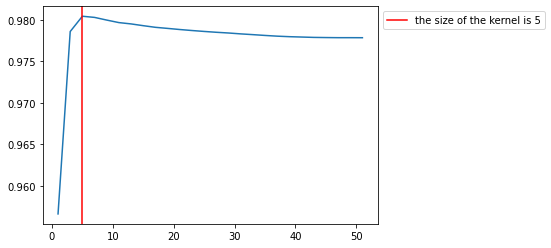

In [141]:
import numpy as np 
import cv2
kernel = np.ones((15,15),np.uint8)


def morph_kernel(pred_mask, kernel =np.ones((15,15),np.uint8),n=51):
    pred_mask_morph = pred_mask.copy()
    i = 1
    x = []
    acc_score = []
    while i <= n: 
        for element in np.unique(pred_mask):
            if element != 0:
                mask = np.zeros((height,width),np.uint8)
                mask[pred_mask == element] = 1
                mask = cv2.medianBlur(mask,i)
                #mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
                #mask = conservative_smoothing_gray(mask, 9)
                #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN , kernel)
                #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN , kernel)
                #mask = cv2.erode(mask,kernel,iterations = 1)
                pred_mask_morph[mask == 1] = element
        x.append(i)
        y_morph = pred_mask_morph.reshape(-1,1)
        acc_score.append(accuracy_score(y, y_morph))
        i = i+2

    return x , acc_score


n, acc_score = morph_kernel(pred_mask)

plt.plot(n,acc_score)
max =  n[acc_score.index(np.max(acc_score))]
plt.axvline(x = max, color = 'r', label = f'the size of the kernel is {max}')
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')


In [145]:
pred_mask_morph = pred_mask.copy()
for element in np.unique(pred_mask):
    if element != 0:
        mask = np.zeros((height,width),np.uint8)
        mask[pred_mask == element] = 1
        mask = cv2.medianBlur(mask,5)
        #mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        #mask = conservative_smoothing_gray(mask, 9)
        #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN , kernel)
        #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN , kernel)
        #mask = cv2.erode(mask,kernel,iterations = 1)
        pred_mask_morph[mask == 1] = element
        
        
        
y_morph = pred_mask_morph.reshape(-1,1)
acc_score = accuracy_score(y, y_morph)
print(f'Accuracy for the image : {acc_score} ')

Accuracy for the image : 0.9770106075216972 


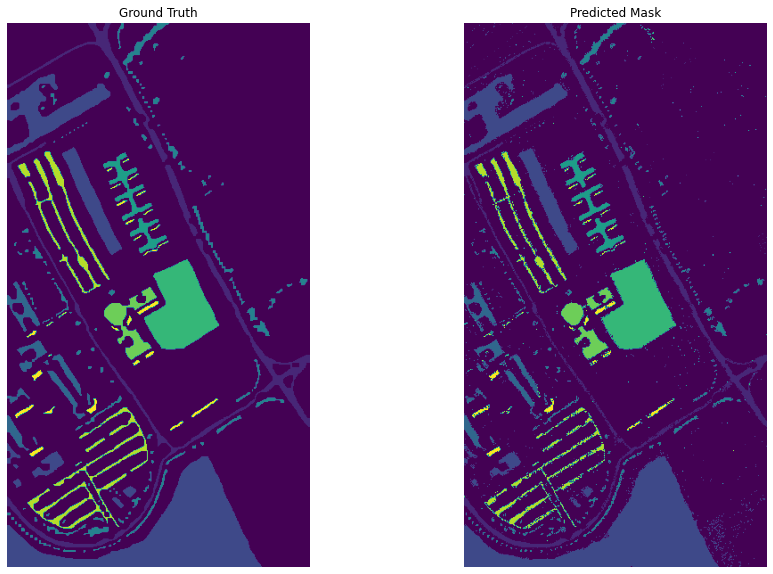

In [146]:

    
        
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(1,2,1)
ax.axis('off')
ax2 = f.add_subplot(1,2,2)
ax2.axis('off')

ax.imshow(hsi_mask)
ax.title.set_text('Ground Truth')


ax2.imshow(pred_mask_morph)
ax2.title.set_text('Predicted Mask')

### We now have to do some parameter tuning

In [151]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2']
    
}
clf = RandomForestClassifier(n_estimators = 50, criterion =  'entropy')
GSCV = GridSearchCV(clf, param_grid,cv= 3)
GSCV.fit(X_train, y_train)



GridSearchCV(cv=3,
             estimator=RandomForestClassifier(criterion='entropy',
                                              n_estimators=50),
             param_grid={'max_features': ['auto', 'sqrt', 'log2']})

In [152]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",GSCV.best_estimator_)
print("\n The best score across ALL searched params:\n",GSCV.best_score_)
print("\n The best parameters across ALL searched params:\n",GSCV.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(criterion='entropy', n_estimators=50)

 The best score across ALL searched params:
 0.8522868154504338

 The best parameters across ALL searched params:
 {'max_features': 'auto'}


In [177]:
y_pred = GSCV.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
print(f'Accuracy for the test : {acc_score} ')

Accuracy for the test : 0.8560591449694632 


Accuracy for the hole image : 0.9566345226615236 


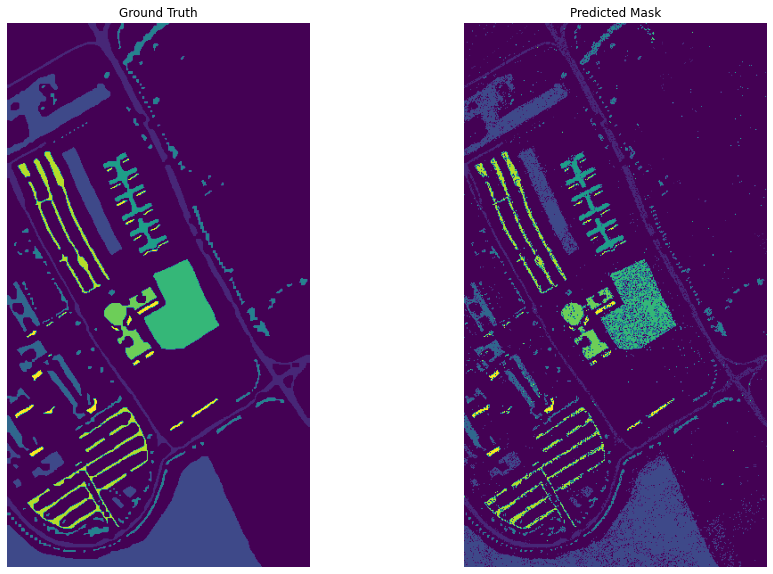

In [178]:
y_pred = GSCV.predict(X)
acc_score = accuracy_score(y, y_pred)
print(f'Accuracy for the hole image : {acc_score} ') 



pred_mask = y_pred.reshape(height, width)
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(1,2,1)
ax.axis('off')
ax2 = f.add_subplot(1,2,2)
ax2.axis('off')

ax.imshow(hsi_mask)
ax.title.set_text('Ground Truth')


ax2.imshow(pred_mask)
ax2.title.set_text('Predicted Mask')

Accuracy for the image after the median blur: 0.9775216972034716 


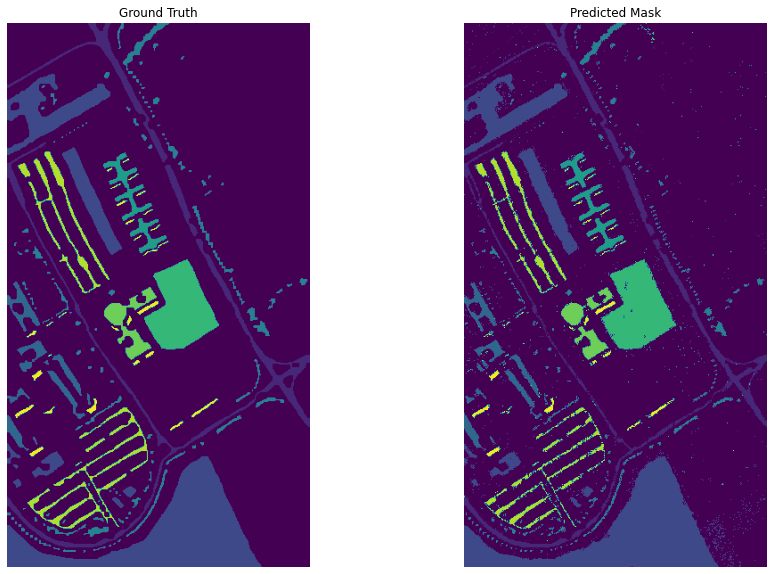

In [180]:
pred_mask_morph = pred_mask.copy()
for element in np.unique(pred_mask):
    if element != 0:
        mask = np.zeros((height,width),np.uint8)
        mask[pred_mask == element] = 1
        mask = cv2.medianBlur(mask,5)
        #mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        #mask = conservative_smoothing_gray(mask, 9)
        #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN , kernel)
        #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN , kernel)
        #mask = cv2.erode(mask,kernel,iterations = 1)
        pred_mask_morph[mask == 1] = element
        
        
        
y_morph = pred_mask_morph.reshape(-1,1)
acc_score = accuracy_score(y, y_morph)
print(f'Accuracy for the image after the median blur: {acc_score} ')

pred_mask = y_morph.reshape(height, width)
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(1,2,1)
ax.axis('off')
ax2 = f.add_subplot(1,2,2)
ax2.axis('off')

ax.imshow(hsi_mask)
ax.title.set_text('Ground Truth')


ax2.imshow(pred_mask)
ax2.title.set_text('Predicted Mask')
